# MFS based MD Simulation -- Analysis

### A Sound scattering simulator based on the method of fundamental solutions


#### Contributors:
*Nicholas St. Clair, Physics (Kleckner Lab), University of California, Merced*

*Arnold Kim, Applied Mathematics, University of California, Merced*

*Dustin Kleckner, Physics, University of California, Merced*

#### Description:
The following notebook imports the position and velocity data of a system of acoustically bound particles whose trajectories are produced according to the Molecular dynamics simulator which takes acoustic forces computed using the Method of Fundamental Solutions.

In [2]:
#import relevant libraries as well as MFS module
import numpy as np
import scipy.special as sp
import time
import os.path
from os import path
import os
import matplotlib.pyplot as plt
from mfs import mfs as MFS
import csv

In [3]:
#define x/y center of mass functions, used to track particle clusters throughout subsequent movie frames
def COM_x(R):
    Np = len(R)
    COM_x = R[:,0].sum() / Np
    return COM_x;

def COM_y(R):
    Np = len(R)
    COM_y = R[:,1].sum() / Np
    return COM_y;

### Import data
The following cell draws data stored into a csv file, the data was created using the jupyter notebook MFS -- Molecular Dynamics Simulation -- Data Creation. One must ensure that all parameters defined in this movie frame generation notebook match those first specified in the data creation notebook.

In [4]:
#define file path where Molecular dynamics data is contained
path = 'MD_data_raw_9/'
#define file name
file = f'MD_Data_ka={ka}_(3).csv'

#initialize empty list to which MD data is imported
data_arr = []

Np = 5 #number of particles in simulation (defined in Data Creation notebook)

#open appropriate file and import trajectory and velocity data, as well as time data
with open(path + file, mode = 'r') as csv_file:
    
    csv_reader = csv.reader(csv_file, delimiter = ',')
    
    for row in csv_reader:
        
        if row != [] and len(row) == Np*6:
            
            data_arr = np.append(data_arr, np.array(row).astype(np.float))
            
        elif row != [] and len(row) != Np*6:
            time = np.array(row).astype(np.float)

#reshape MD data
data_arr = data_arr.reshape(-1,30)

#define new array to store particle positions only, and write particle positions to this array
cp = np.zeros((len(data_arr),Np,3))
for j in range(len(data_arr)):
    for i in range(Np):
        cp[j,i] = data_arr[j,6*i:6*i+3]

### Visualize system evolution
The first cell below plots the initial and final state of a particle cluster (as well as trajectories between the two states) which evolves according to simulated acoustic forces. The second cell below plots the pressure field on the levitation plane of the particles at a specified time within the simulation.

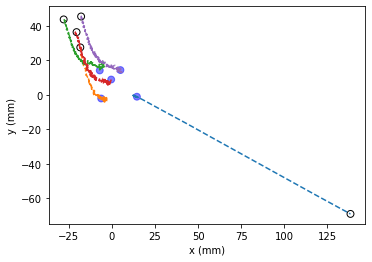

In [14]:
#define simulation parameters necessary to visualize trajectories
ka = 1.466 #size parameter
f = 40000 #sound frequency (Hz)
c = 343 #sound speed in air (m/s)
k = 2*np.pi*f / c 
a = ka / k #particle radius (m)

#set scale to rescale position data to mm from m
sc = 1000
#plot initial and final particle positions as well as trajectories linking the two states
for i in range(Np):
    plt.plot(sc*data_arr[:,6*i], sc*data_arr[:,6*i+1], '--')
    plt.gca().add_artist(plt.Circle((sc*data_arr[0,6*i],sc*data_arr[0,6*i+1]), sc*a, color = 'blue', alpha = 0.5))
    plt.gca().add_artist(plt.Circle((sc*data_arr[-1,6*i],sc*data_arr[-1,6*i+1]), sc*a, color = 'white', ec = 'k'))
#ensure equal aspect ratio, and label axes
plt.gca().set_aspect(1)
plt.xlabel('x (mm)')
plt.ylabel('y (mm)');

<ipython-input-24-a018c22e5374>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels((xlabels*10001).astype(int)/10, fontsize = 14)
<ipython-input-24-a018c22e5374>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels((ylabels*10001).astype(int)/10, fontsize = 14)


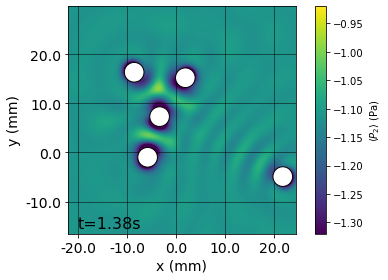

In [24]:
#define parameters necessary to visualize pressure field on particle levitation plane
λ = 2*np.pi/k #wavelength (m)
ω = c * k #angular frequency (Hz)
rho = 1.225 #mass density of air (kg/m^3)
phi_a =  4e2 / (rho*ω) #amplitude of incident velocity potential field (m^2/s), specified in data creation notebook

#call an instance of the MFS scatter class using parameters defined above
scat = MFS.Scatter(N=92, k=k, a=a, phi_a = phi_a, rho = rho, source_depth=0.5, Nq=8)
#set incident field profile (plane standing wave)
scat.incoming_planewaves([1, -1], [(0, 0, 1), (0, 0, -1)])

#set desired framnumber to visualize
fr = 270
#copy particle position data to a new array
cpt = np.copy(cp)
#solve for scattered acoustic fields based on particle positions
scat.solve(cpt[fr])

#set number of grid points over which the second order pressure field is visualized
N = 400
#set default extent within which pressure field is visualized (square window)
lim = 2.7*λ
#find center of mass of configuration in the x and y directions
dx = COM_x(cpt[fr])
dy = COM_y(cpt[fr])
#find maximum extent between particles in the configuration
maxext = np.amax([np.amax(cpt[fr,:,0])-np.amin(cpt[fr,:,0]),\
                   np.amax(cpt[fr,:,1])-np.amin(cpt[fr,:,1])])
 
#if maximum extent is greater than a certain ratio of the default extent, reset visualization region
if maxext > 1.5*lim:
    lim = maxext/1.5
    dx = ((cpt[fr,:,0]).max() + (cpt[fr,:,0]).min())/2
    dy = ((cpt[fr,:,1]).max() + (cpt[fr,:,1]).min())/2
    

#define grid over which field is visualized
points = (2*lim*(np.arange(N) + 0.5)/N - lim)
X = np.zeros((N, N, 3))
X[:, :, 0] += points.reshape(1, -1) + dx
X[:, :, 1] += points.reshape(-1, 1) + dy
extent = [-lim +dx, lim +dx, -lim +dy, lim +dy]
#show second order pressure field over the predefined window
plt.imshow(scat.p2(X), extent =extent, origin = 'lower', clim = (-1.32,-0.92))
cbar = plt.colorbar(label = r'$ \langle P_{2} \rangle $ (Pa)')

#ensure that gridpoints in the x and y directions are equally spaced
xlabels, xlocations = plt.xticks()
ylabels, ylocations = plt.yticks()
plt.gca().set_xticklabels((xlabels*10001).astype(int)/10, fontsize = 14)
plt.gca().set_yticklabels((ylabels*10001).astype(int)/10, fontsize = 14)

#plot the particle in their respective positions within the total acoustic field
for i in range(Np):
    plt.gca().add_artist(plt.Circle((cpt[fr,i,0],cpt[fr,i,1]),a, color='w', ec='k', zorder =2))
#print timestamp in lower left corner of plot
xlim = plt.xlim()
ylim = plt.ylim()
t_stamp = int((fr/len(cpt))*1001)/100
plt.text(xlim[0] + 0.08*lim ,ylim[0] + 0.05*lim, f't={t_stamp}s', fontsize = 16);

#show gridlines on the plot, useful for realizing cluster motion in the produced movie
plt.grid(color = 'k',linewidth = 0.5)
#show relevant x and y labels
plt.xlabel('x (mm)', fontsize = 14)
plt.ylabel('y (mm)', fontsize = 14);
plt.tight_layout();

### Data management
The following cell can be used to ensure that the size of the data array corresponds to a desired frame rate used in movie production. This step can be skipped if one is fine using an arbitrary frame rate, although generally time steps within the simulation are so small as to invoke an exceedingly high frame rate, one which corresponds to the final movie having unnecessarily large filesize.

In [23]:
#Find uncut fps, convert to a reasonable fraction over desired fps (60)
fps = 60.0
print('No. of frames:',len(cpt),', Duration of simulation:', time[-1], 's')
print('Uncut fps:', (len(cpt)/time[-1]))
print('Ratio of uncut frame rate to desired frame rate:',float(len(cpt[:-156])/time[-1])/fps)
#create a new copy of the array with end frames cut out so that it can be scaled to the desired fps
cptcut = np.copy(cpt[:-156])
#set the following parameter (n) equal to frame rate ratio printed above
n = 3
#only include every nth frame in movie production
cptcut = np.array([x for i,x in enumerate(cptcut) if i%n == 0])
#ensure that reformatted frame rate matches desired frame rate (fps)
print('cut fps:',len(cptcut)/time[-1])

No. of frames: 1956 , Duration of simulation: 10.0 s
Uncut fps: 195.6
Ratio of uncut frame rate to desired frame rate: 3.0
cut fps: 60.0


### Movie frame production
The following cell creates subsequent frames corresponding to particle motions which evolve according to the simulated acoustic interaction forces. It also visualizes the second order pressure field on the levitation plane of the particles within each frame. The frames are saved to a common path and can be used with an external video compiler (ffmpeg) to create a movie of the acoustically bound system evolving in time.

In [96]:
#define path to folder within which movie frames will be saved
path ='MD_Movie_Images/'
#print out the number of frames expected to be produced
print('# of images to produce:', len(cptcut))

#call instance of scatter class and define incident field profile
scat = MFS.Scatter(N=92, k=k, a=a, phi_a=phi_a,rho = rho, source_depth=0.5, Nq=8)
scat.incoming_planewaves([1, -1], [(0, 0, 1), (0, 0, -1)])
#loop through the desired number of frames
for n in range(len(cptcut)):
    
    #solve the scatter class using particle positions in frame n
    scat.solve(cptcut[n])
    
    #set number of gridpoints over which pressure field is visualized
    N = 200
    #set default extent of visualization window
    lim = 2.7*λ
    #find center of mass of configuration in the x and y directions at frame n
    dx = COM_x(cptcut[n])
    dy = COM_y(cptcut[n])
    #find maximum extent between particles in the configuration at frame n 
    maxext = np.amax([np.amax(cptcut[n,:,0])-np.amin(cptcut[n,:,0]),\
                   np.amax(cptcut[n,:,1])-np.amin(cptcut[n,:,1])])
    
    #if maximum extent is great than a ratio of default window extent, reset window extent to compensate
    if maxext > 1.3*lim:
        lim = maxext/1.3
        dx = ((cptcut[n,:,0]).max() + (cptcut[n,:,0]).min())/2
        dy = ((cptcut[n,:,1]).max() + (cptcut[n,:,1]).min())/2
    
    #define grid over which field is visualized
    points = 2*lim*(np.arange(N) + 0.5)/N - lim
    X = np.zeros((N, N, 3))
    X[:, :, 0] += points.reshape(1, -1) +dx
    X[:, :, 1] += points.reshape(-1, 1) +dy
    extent = [-lim +dx, lim +dx, -lim +dy, lim +dy]
    #show the second order pressure field on the levitation plane of the particles
    #note that the clim parameter may need to be varied to observe meaningful field structure
    plt.imshow(scat.p2(X), extent =extent, origin = 'lower', clim = (-1.32,-0.92))
    #show a grid on the field vis window, useful for observing motion of cluster
    plt.grid(color = 'k', linewidth = 0.5)
    #show the colorbar corresponding to field values
    cbar = plt.colorbar(shrink = 0.95)
    cbar.set_label(r'    $ \langle p_{2} \rangle $ (Pa)', size =10, labelpad = 5)
    cbar.ax.tick_params(labelsize=8)
    #ensure that axis spacing is equal between x and y
    xlabels, xlocations = plt.xticks()
    ylabels, ylocations = plt.yticks()
    plt.gca().set_xticklabels((xlabels*10001).astype(int)/10)
    plt.gca().set_yticklabels((ylabels*10001).astype(int)/10)
    
    #plot the locations of the particles at the nth frame
    for i in range(Np):
        plt.gca().add_artist(plt.Circle((cptcut[n,i,0], cptcut[n,i,1]), a, color='w', ec='k', zorder = 2))
    
    #include a timestamp corresponding to the nth frame in the lower left corner of the current plot
    xlim = plt.xlim()
    ylim = plt.ylim()
    t_stamp = int((n/len(cptcut))*1001)/100
    plt.text(xlim[0] + 0.08*lim ,ylim[0] + 0.05*lim, f't={t_stamp}s', fontsize = 16);     
    
    #label axes and include title showing particle densities if desired
    #plt.title(r'ρ$_p$=100kg/m$^3$')
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)');
    
    #ensure that frame naming involves the same number of digits in the numbering scheme 
    #(good to 99999 frames)
    if n < 10:
        filename = f'MD_frame_0000{n}.png'
    elif n > 9 and n < 100:
        filename = f'MD_frame_000{n}.png'
    elif n > 99 and n < 1000:
        filename = f'MD_frame_00{n}.png'
    elif n > 999 and n < 10000:
        filename = f'MD_frame_0{n}.png'
    elif n > 9999 and n < 100000:
        filename = f'MD_frame_{n}.png'
    #save subsequent movie frame at the desired path and w/ desired frame name
    plt.savefig(path+filename, dpi = 500)
    #close the plot
    plt.close()
    
    '''Note that this notebook outputs subsequent frames in order to be used with video compiler ffmpeg,
    the notebook itself does not compile the videos, instead the compilation software is run in a terminal
    on the users desktop. See more details on how to implement ffmpeg here: https://www.ffmpeg.org/'''

# of images to produce: 600


<ipython-input-96-befe979e250c>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels((xlabels*10001).astype(int)/10)
<ipython-input-96-befe979e250c>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels((ylabels*10001).astype(int)/10)
